# Importing Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Data Preparation

In [3]:


labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('../data/Brain_Tumor_Dataset','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../data/Brain_Tumor_Dataset','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 195.42it/s]


**Sample Images**

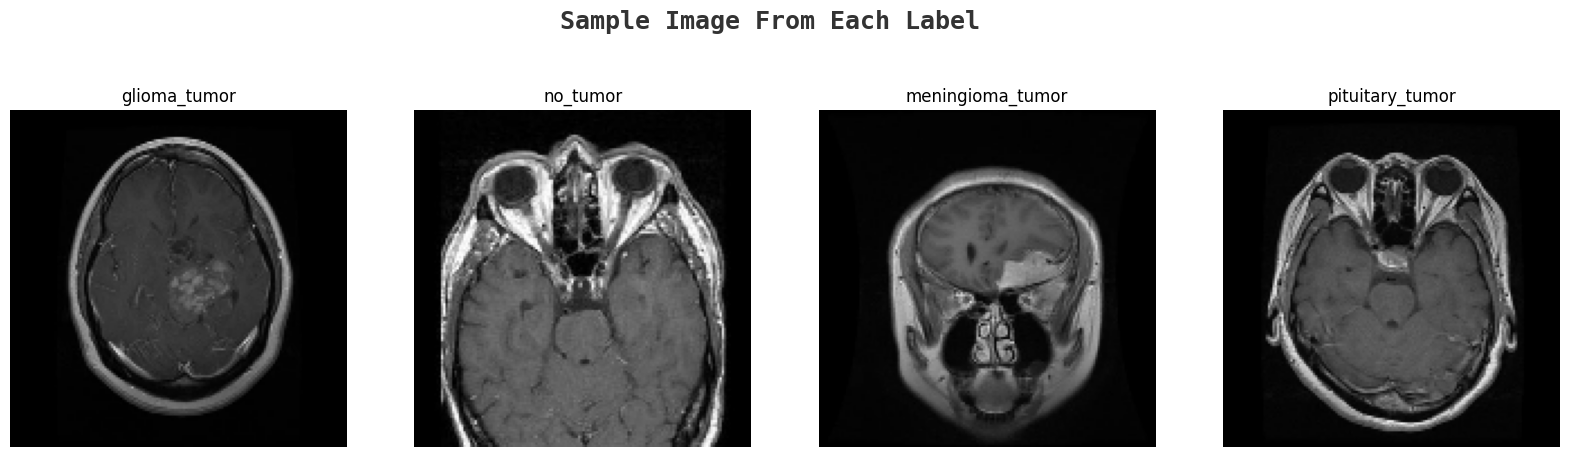

In [4]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

# Dividing the dataset into Training and Testing sets.


In [5]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [6]:
X_train.shape

(2937, 150, 150, 3)

In [7]:
X_test.shape

(327, 150, 150, 3)

In [8]:
y_train.shape

(2937,)

In [9]:
y_test.shape

(327,)

# One Hot Encoding

**Performing One Hot Encoding on the labels after converting it into numerical values:**

In [10]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# Transfer Learning CNN


Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the **EfficientNetB0** model which will use the weights from the ImageNet dataset.

The include_top parameter is set to False so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!



In [11]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while pooling. This really helps in decreasing the computational load on the machine while training.

**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The rate parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the softmax function which is a generalization of the sigmoid function.


In [12]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)


In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

**Compile The Model**

In [14]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

**Callbacks** -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.

By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using **TensorBoard**, **ModelCheckpoint** and **ReduceLROnPlateau** callback functions



In [15]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)


You must install pydot (`pip install pydot`) for `plot_model` to work.


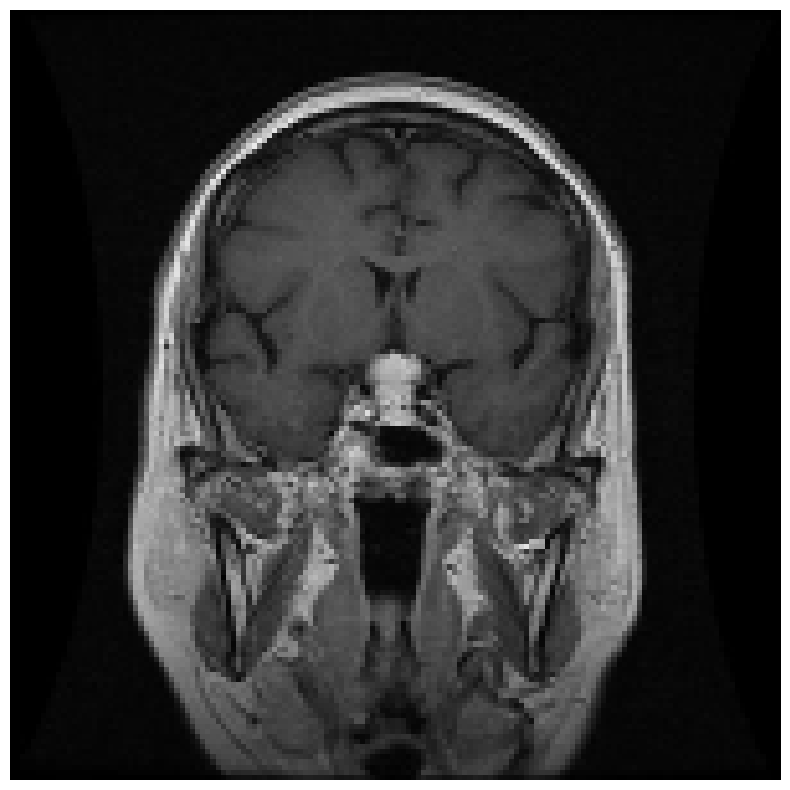

In [18]:
plot_model(model, show_shapes=True, dpi=150)

# Display the plot
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()


# Training The Model

**Note**: The training takes alot of time! ~ 2 hours for me (Using CPU)
Barely took 5 minutes with the GPU.

In [19]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7284 - loss: 0.6887
Epoch 1: val_accuracy improved from -inf to 0.83673, saving model to effnet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.7296 - loss: 0.6860 - val_accuracy: 0.8367 - val_loss: 0.5468 - learning_rate: 0.0010
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9306 - loss: 0.2106
Epoch 2: val_accuracy did not improve from 0.83673
83/83 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9306 - loss: 0.2104 - val_accuracy: 0.8027 - val_loss: 0.5083 - learning_rate: 0.0010
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9483 - loss: 0.1452
Epoch 3: val_accuracy improved from 0.83673 to 0.89116, saving model to effnet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9484 - loss: 0.1450 - val_accuracy: 0.8912 - val_loss: 0.4405 - learning_rate: 0.0010
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9672 - loss: 0.0930
Epoch 4: val_accuracy did not 

# Plotting The Accuracy & Loss

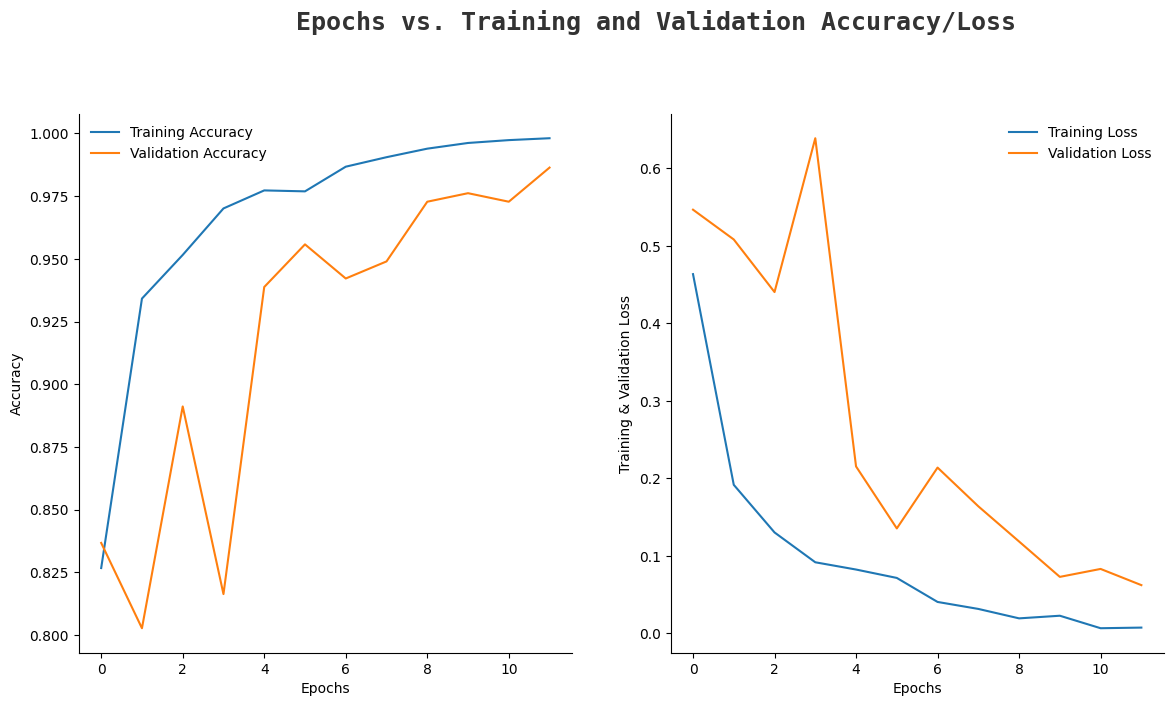

In [21]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss,label ='Training Loss')
ax[1].plot(epochs, val_loss, label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()


# Prediction

I've used the **argmax** function as each row from the prediction array contains four values for the respective labels. The maximum value which is in each row depicts the predicted output out of the 4 possible outcomes.
So with argmax, I'm able to find out the index associated with the predicted outcome.


In [22]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 354ms/step


# Evaluation

In this:

0. Glioma Tumor
1. No Tumor
2. Meningioma Tumor
3.  Pituitary Tumor

**Classification Report**

In [23]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        97
           1       1.00      1.00      1.00        48
           2       0.98      0.97      0.98       101
           3       0.99      1.00      0.99        81

    accuracy                           0.98       327
   macro avg       0.99      0.99      0.99       327
weighted avg       0.98      0.98      0.98       327



**Confusion Matrix**

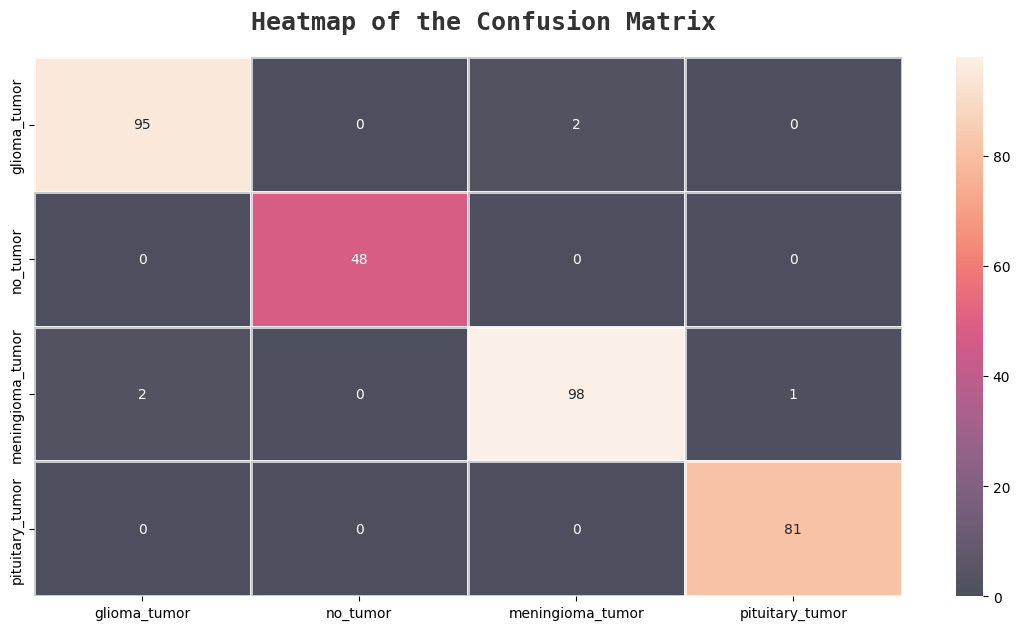

In [24]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()


# CNN Approach

**Mode: Sequential CNN**

In [25]:
model_cnn=Sequential()
model_cnn.add(Input(shape=(224,224,3)))
model_cnn.add(Conv2D(128,(3,3)))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(64,(3,3)))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(32,(3,3)))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Flatten())
model_cnn.add(Dense(128,activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(64,activation='relu'))
model_cnn.add(Dense(4,activation='softmax'))
model_cnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

You must install pydot (`pip install pydot`) for `plot_model` to work.


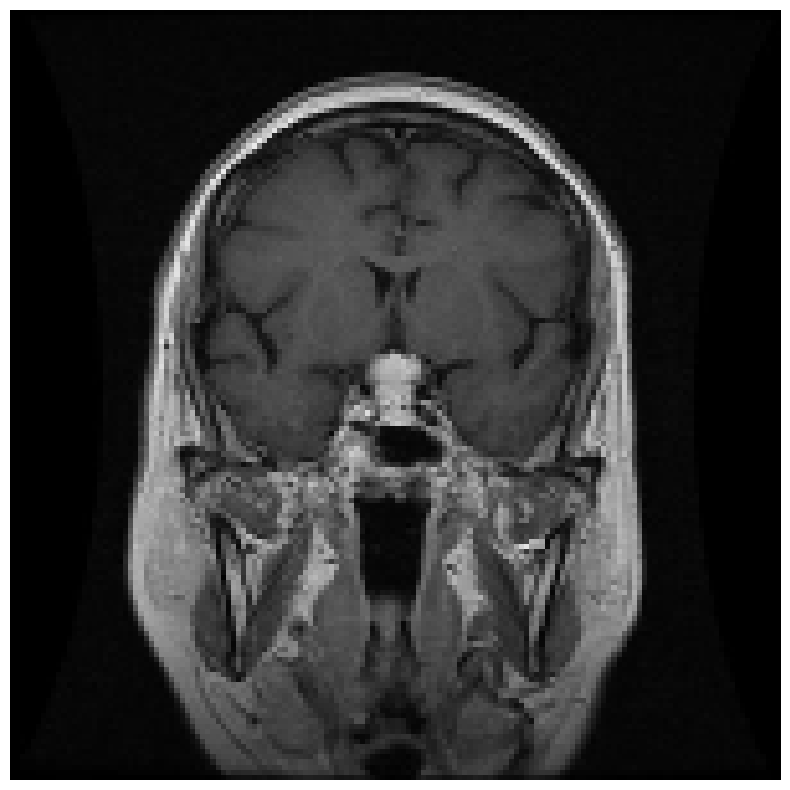

In [26]:
plot_model(model_cnn, show_shapes=True, dpi=150)

# Display the plot
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()


**Converting X_train & X_test**

In [27]:
import cv2
import numpy as np

resized_X_train = []
for img in X_train:
    resized_img = cv2.resize(img, (224, 224))
    resized_X_train.append(resized_img)

resized_X_train = np.array(resized_X_train)

resized_X_test = []
for img in X_test:
    resized_img = cv2.resize(img, (224, 224))
    resized_X_test.append(resized_img)

resized_X_test = np.array(resized_X_test)


**Compiling The Model**

In [28]:
model_cnn.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

**Training**

In [29]:
history = model_cnn.fit(resized_X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4493 - loss: 2.0846
Epoch 1: val_accuracy did not improve from 0.98639
83/83 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.4500 - loss: 2.0781 - val_accuracy: 0.2211 - val_loss: 3.4357 - learning_rate: 0.0010
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6154 - loss: 0.9671
Epoch 2: val_accuracy did not improve from 0.98639
83/83 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.6156 - loss: 0.9662 - val_accuracy: 0.6293 - val_loss: 1.1017 - learning_rate: 0.0010
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6723 - loss: 0.7725
Epoch 3: val_accuracy did not improve from 0.98639
83/83 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.6726 - loss: 0.7718 - val_accuracy: 0.7483 - val_loss: 0.5820 - learning_rate: 0.0010
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7702 - loss: 0.5787
Epoch 4: val_accuracy did not improve from 0.98639
83/83 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - ac

# Plotting The Accuracy & Loss

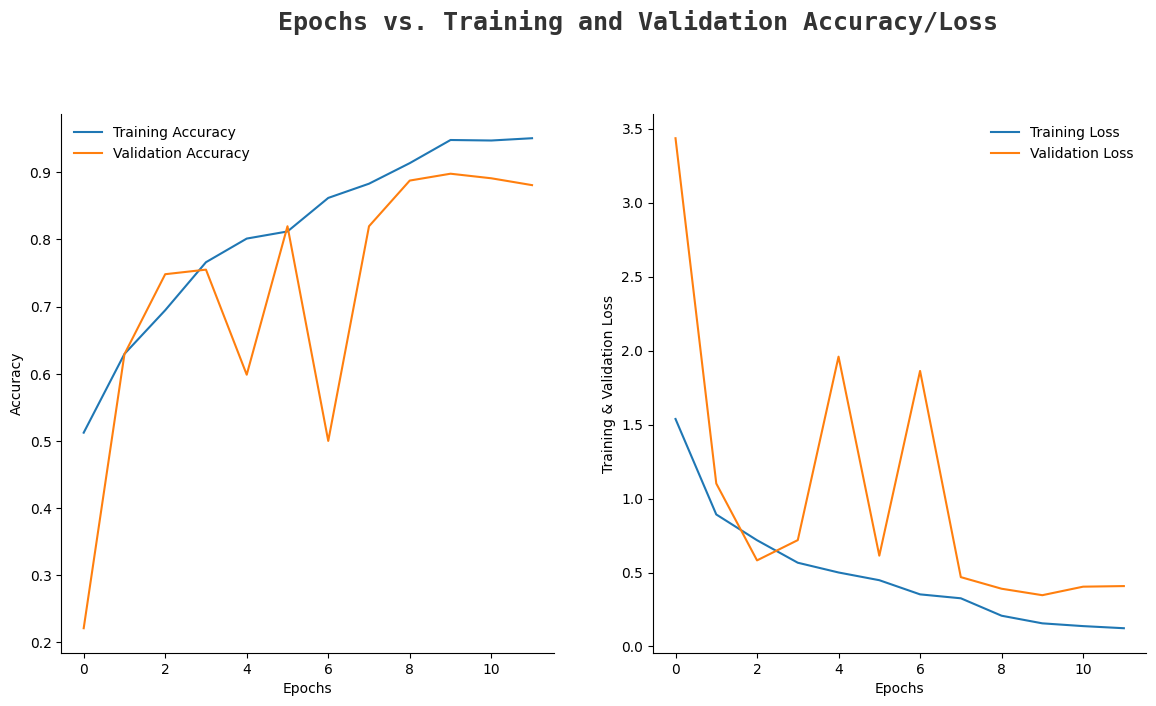

In [30]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss,label ='Training Loss')
ax[1].plot(epochs, val_loss, label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

# Prediction

In [31]:
pred = model_cnn.predict(resized_X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step


# Evaluation

In [32]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.97      0.71      0.82        97
           1       0.91      0.85      0.88        48
           2       0.73      0.96      0.83       101
           3       0.97      0.95      0.96        81

    accuracy                           0.87       327
   macro avg       0.90      0.87      0.87       327
weighted avg       0.89      0.87      0.87       327



# Conclusion: Transfer Learning (EfficientNet) Vs CNN (Sequential)

**We could clearly observe that both the approaches worked quite well yet the TL worked better (98% accuracy)
comparing to the CNN (89% accuracy)**

# Upload Image To Test

**I've made these Widgets in which we can upload images from our local machine and predict whether the MRI scan has a Brain Tumour or not and to classify which Tumor it is.**

In [27]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [28]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [29]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

In [34]:
import pickle 
# Save the model architecture and weights using Keras function
model_config = model.to_json()
with open('brain_model_config.json', 'w') as json_file:
    json_file.write(model_config)

# Save the weights
model.save_weights('brain_model.weights.h5')

# Save the entire model using pickle
with open('brain_model.pkl', 'wb') as pickle_file:
    pickle.dump(model, pickle_file)


AttributeError: Can't pickle local object 'Layer._initializer_tracker.<locals>.<lambda>'

In [35]:
from keras.models import load_model

# Save the model
model.save('brain_model.h5')

# Later, you can load the model
loaded_model = load_model('brain_model.h5')


TO LOAD THE MODEL

import pickle
from keras.models import model_from_json

# Load the dictionary from the pickle file
with open('brain_model.pkl', 'rb') as pickle_file:
    model_data = pickle.load(pickle_file)

# Load the model architecture
loaded_model = model_from_json(model_data['config'])

# Load the weights into the model
loaded_model.load_weights(model_data['weights_path'])
